In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from shapely import geometry
from tqdm import tqdm
import random
import torch

In [28]:
n = 8

pattern = (0.5, 1)
slab = ((0, 0), (0, 2), (2, 2), (2, 0))
rnd_coef = [0.1, 0.1, 0.1]
min_bound = np.array([0, 0, 0])
max_bound = np.array([2, 2, 2 * np.pi])

In [29]:

def real_real_cords(x):
    p = x[:2]
    phi = x[2]
    return [
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ]



In [30]:


def s_intersection(a, b):
    poly1 = geometry.Polygon(a)
    poly2 = geometry.Polygon(b)
    intersection = poly1.intersection(poly2)
    return intersection.area

def real_cords(x):
    p = x[:2]
    phi = x[2]
    return geometry.Polygon([
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ])

def torch_func(patterns):
    patterns = patterns.detach().cpu().numpy()
    s = 0
    for i in range(len(patterns)):
        for j in range(i + 1, len(patterns)):
            s += s_intersection(real_cords(patterns[i]), real_cords(patterns[j]))
    slab_poly = geometry.Polygon(slab)
    for pat in patterns:
        poly = real_cords(pat)
        s += poly.area - s_intersection(slab_poly, poly)
    return s

def func(patterns):
    s = 0
    for i in range(len(patterns)):
        for j in range(i + 1, len(patterns)):
            s += s_intersection(real_cords(patterns[i]), real_cords(patterns[j]))
    slab_poly = geometry.Polygon(slab)
    for pat in patterns:
        poly = real_cords(pat)
        s += poly.area - s_intersection(slab_poly, poly)
    return s


In [31]:

def get_neighbors(solution):
    neighbors = []
    n = len(solution)
    for _ in range(10):  # 10 соседей каждый раз
        neighbor = list(solution)
        # случайно выбираем индекс для мутации
        idx = random.randint(0, n - 1)
        old_coord = neighbor[idx]
        # новый набор координат с небольшим случайным смещением
        new_coord = (
            max(min_bound[0], min(old_coord[0] + random.uniform(-rnd_coef[0], rnd_coef[0]), max_bound[0])),
            max(min_bound[1], min(old_coord[1] + random.uniform(-rnd_coef[1], rnd_coef[1]), max_bound[1])),
            max(min_bound[2], min(old_coord[2] + random.uniform(-rnd_coef[2], rnd_coef[2]), max_bound[2])),
        )
        neighbor[idx] = new_coord
        neighbors.append(tuple(neighbor))
    return neighbors

def tabu_search(initial_solution, max_iterations, tabu_list_size):
    current_solution = initial_solution
    best_solution = initial_solution
    tabu_list = []

    for _ in tqdm(range(max_iterations)):
        neighbors = get_neighbors(current_solution)
        best_neighbor = None
        best_neighbor_fitness = float('inf')

        for neighbor in neighbors:
            if neighbor not in tabu_list:
                fitness = func(neighbor)
                if fitness < best_neighbor_fitness:
                    best_neighbor = neighbor
                    best_neighbor_fitness = fitness

        if best_neighbor is None:
            break

        current_solution = best_neighbor
        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_list_size:
            tabu_list.pop(0)

        if func(current_solution) < func(best_solution):
            best_solution = current_solution

    return best_solution

# Инициализация: n наборов координат
n = 8
initial_solution = []
for _ in range(n):
    initial_solution.append((
        random.uniform(min_bound[0], max_bound[0]),
        random.uniform(min_bound[1], max_bound[1]),
        random.uniform(min_bound[2], max_bound[2])
    ))
initial_solution = tuple(initial_solution)  # чтоб была хешируемой для табу-листа

max_iterations = 1000
tabu_list_size = 10  

best_solution = tabu_search(initial_solution, max_iterations, tabu_list_size)

print("Best solution:", best_solution)
print("Best fitness:", func(best_solution))


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:15<00:00, 13.24it/s]

Best solution: ((np.float64(1.0079086434780027), np.float64(0.48991240491276045), np.float64(1.5474675840992378)), (np.float64(0.45712618867357774), np.float64(1.5091064317989162), np.float64(4.722495156815391)), (np.int64(0), np.float64(0.9937244909137524), np.float64(6.269631140945295)), (np.float64(1.4632150879274248), np.float64(1.0548914358784045), np.float64(6.191639649155111)), (np.float64(0.5105561507333708), np.float64(2.0), np.float64(4.73730982619134)), (np.float64(1.0004634971627833), np.float64(1.0081878713144319), np.float64(4.719687455801347)), (np.float64(0.010598217310232985), np.float64(0.5017183110936928), np.float64(4.7088238253329875)), (np.float64(1.0028798109180803), np.float64(0.49066249627648734), np.float64(4.698884964927697)))
Best fitness: 0.10631733131391233


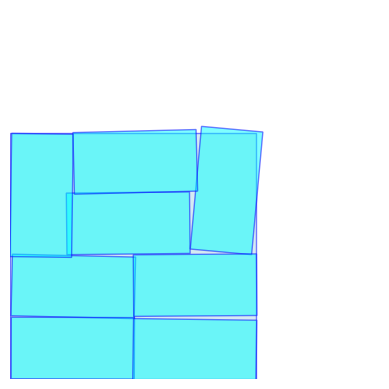

In [32]:
fig, ax = plt.subplots()

polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in best_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)


ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()

plt.show()

In [35]:


def grad(best_solution):
    x = best_solution.detach().numpy()
    
    xt = torch.tensor(x, requires_grad=True)
    optimizer = torch.optim.Adam([xt], lr=0.001)
    for i in range(100):
        optimizer.zero_grad()
        f = torch_func(xt)
        f.backward()
        optimizer.step()
    return xt


def gradient_descent(func, params,lr, max_iters):

    params = torch.tensor(params, requires_grad= True)
    optimizer = torch.optim.Adam([params], lr)


    for i in tqdm(range(max_iters )):
        optimizer.zero_grad()          # обнуляем градиенты с прошлой итерации
        loss = func(params)            # вычисляем значение функции потерь
        loss.backward()                # вычисляем градиенты
        optimizer.step()               # обновляем параметры
    
    return params.detach().numpy() 




best_solution_after_ts = best_solution  

improved_solution = gradient_descent(torch_func, best_solution_after_ts, lr=0.01, max_iters=1000)

print("Improved solution:", improved_solution)
print("Improved fitness:", func(improved_solution))


  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'float' object has no attribute 'backward'

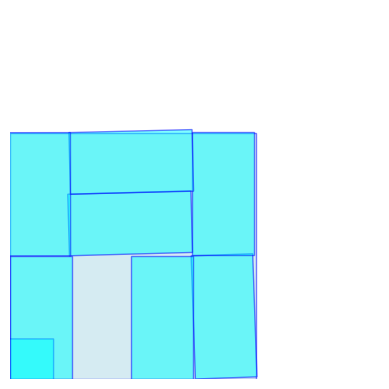

Улучшение -0.4590706678505428


In [ ]:
# Визуализация
fig, ax = plt.subplots()

polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in improved_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)


ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()

plt.show()
print ("Улучшение", func(best_solution)-func(improved_solution))
